In [1]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 12]

import csv

In [2]:
RNA3_seq = 'GGAUAAAGAGUUGGGUGGGUGGGUGGGUCAGAAGCACAGAUAUCCUGGUUUGCUCCUGAGGAUCAUGGAUACGGUACUGAAGUUUCUACUAAGAACACACCAUGCUCAGAGAACAAACUUGACAUCCAGGA'
RNA9_seq = 'GGAUAAAGAGUUGAGUGAGUGAGUGAGUCAGAAGCACAGAUAUCCUGGUUUGCUCCUGAGGAUCAUGGAUACGGUACUGAAGUUUCUACUAAGAACACACCAUGCUCAGAGAACAAACUUGACAUCCAGGA'


# Data import

In [3]:
def import_to_dict(filename):
    table = {}
    table['dwell'], table['mean'], table['median'] = {}, {}, {}
    with open(filename) as tsvfile:
        tsvreader = csv.reader(tsvfile, delimiter="\t")
        for line in tsvreader:
            # some rows are headers (there are multiple headers in the file)
            # so we check for the line identifier
            if len(line)==9 and line[0]!='ref_pos':
                # if this base number is alr in the keys just update
                if line[0] in table['dwell'].keys():
                    table['dwell'][line[0]].append(float(line[3]))
                # if not then create first then update
                else:
                    table['dwell'][line[0]] = []
                    table['dwell'][line[0]].append(float(line[3]))
                # same for mean
                if line[0] in table['mean'].keys():
                    table['mean'][line[0]].append(float(line[6]))
                else:
                    table['mean'][line[0]] = []
                    table['mean'][line[0]].append(float(line[6]))
                # same for median
                if line[0] in table['median'].keys():
                    table['median'][line[0]].append(float(line[7]))
                else:
                    table['median'][line[0]] = []
                    table['median'][line[0]].append(float(line[7]))
    return table


RNA3 = import_to_dict("tables/out_eventalign_collapse_RNA3.tsv")
RNA3L = import_to_dict("tables/out_eventalign_collapse_RNA3_PhenDC.tsv")
RNA9 = import_to_dict("tables/out_eventalign_collapse_RNA9.tsv")


In [7]:
print(len(RNA3['dwell']['10']))

743


# Linear plot (averaged values)

In [8]:
def make_df_np(RNA_dict):
    pos = [int(key) for key in RNA_dict['dwell'].keys()] 
    dwell = [np.mean(RNA_dict['dwell'][key]) for key in RNA_dict['dwell'].keys()]
    mean = [np.mean(RNA_dict['mean'][key]) for key in RNA_dict['mean'].keys()] 
    std = [np.std(RNA_dict['mean'][key]) for key in RNA_dict['mean'].keys()] 
    pos = np.array(pos)
    dwell = np.array(dwell)
    mean = np.array(mean)
    std = np.array(std)
    data = np.vstack((pos, dwell))
    data = np.vstack((data, mean))
    data = np.vstack((data, std))
    return data.T

data3 = make_df_np(RNA3)
# sort by pos (base) number so it's sequential
data3 = data3[np.argsort(data3[:,0])]

data3L = make_df_np(RNA3L)
data3L = data3L[np.argsort(data3L[:,0])]

data9 = make_df_np(RNA9)
data9 = data9[np.argsort(data9[:,0])]

In [10]:
import os, io, random
import string

from Bio.Seq import Seq
from Bio.Align import MultipleSeqAlignment
from Bio import AlignIO, SeqIO

import panel as pn
import panel.widgets as pnw
pn.extension()

from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, Plot, Grid, Range1d, SingleIntervalTicker, BoxAnnotation
from bokeh.models.glyphs import Text, Rect
from bokeh.layouts import gridplot
from bokeh.io import output_notebook, output_file

# interactive graph will be saved to the file
output_file('out_bokeh.html')


def get_colors(seqs):
    """make colors for bases in sequence"""
    text = [i for s in list(seqs) for i in s]
    clrs =  {'A':'red','U':'green','G':'orange','C':'blue','-':'white'}
    colors = [clrs[i] for i in text]
    return colors


def view_aln_line(seqs, ids, data3, data3L, data9, fontsize="9pt", plot_width=800):
    """Bokeh sequence alignment view"""

    #make sequence and id lists from the aln object  
    text = [i for s in list(seqs) for i in s]
    colors = get_colors(seqs)    
    N = len(seqs[0])
    S = len(seqs)    
    width = .4

    x = np.arange(1,N+1)
    # OFFSET FOR THE SEQ SO IT STARTS EXACTLY AT 0
    x = x - 0.5
    y = np.arange(0,S,1)
    #creates a 2D grid of coords from the 1D arrays
    xx, yy = np.meshgrid(x, y)
    #flattens the arrays
    gx = xx.ravel()
    gy = yy.flatten()
    #use recty for rect coords with an offset
    recty = gy+.5
    h= 1/S
    #now we can create the ColumnDataSource with all the arrays
    source = ColumnDataSource(dict(x=gx, y=gy, recty=recty, text=text, colors=colors))
    plot_height = len(seqs)*15+50
    x_range = Range1d(0, N+1, bounds='auto')
    if N>150:
        viewlen=150
    else:
        viewlen=N
    #view_range is for the close up view
    view_range = (0, viewlen)
    tools="xpan, xwheel_zoom, reset, save"

    #plot of the values of interest
    p = figure(title=None, plot_width= plot_width, plot_height=400,
               x_range=view_range, background_fill_color='#f8f8f8',
               tools=tools, toolbar_location='below')
    # OFFSET BY 0.5 so points correspond precisely to bases
    p.line(x=data9[:,0]+0.5, y=data9[:,1], line_width=2, alpha=0.7, legend_label='RNA9')
    p.line(x=data3[:,0]+0.5, y=data3[:,1], line_width=2, color='#cf3c4d', alpha=0.7, legend_label='RNA3')
    p.line(x=data3L[:,0]+0.5, y=data3L[:,1], line_width=2, color='#71d972', alpha=0.7, legend_label='RNA3-PhenDC')
    
    # highlight the G-quad motif box
    low_box = BoxAnnotation(left=12, fill_alpha=0.0, fill_color='green')
    mid_box = BoxAnnotation(left=12, right=27, fill_alpha=0.1, fill_color='orange')
    high_box = BoxAnnotation(right=27, fill_alpha=0.0, fill_color='green')
    p.add_layout(low_box)
    p.add_layout(mid_box)
    p.add_layout(high_box)
    
    p.xgrid.ticker = SingleIntervalTicker(interval=1)
    p.yaxis.visible = True
    p.xaxis.visible = False
    p.grid.visible = True  

    #sequence text view with ability to scroll along x axis
    p1 = figure(title=None, plot_width=plot_width, plot_height=plot_height,
                x_range=view_range, y_range=ids, tools="xpan,reset",
                min_border=0, toolbar_location='below')#, lod_factor=1)          
    glyph = Text(x="x", y="y", text="text", text_align='center',text_color="black",
                text_font="monospace",text_font_size=fontsize)
    rects = Rect(x="x", y="recty",  width=1, height=1, fill_color="colors",
                line_color=None, fill_alpha=0.4)
    p1.add_glyph(source, glyph)
    p1.add_glyph(source, rects)

    p1.grid.visible = False
    p1.xaxis.major_label_text_font_style = "bold"
    p1.yaxis.minor_tick_line_width = 0
    p1.yaxis.major_tick_line_width = 0

    p = gridplot([[p],[p1]], toolbar_location='below')
    return p


# PLOT
p = view_aln_line([RNA3_seq, RNA9_seq], ['RNA3', 'RNA9'], data3, data3L, data9, plot_width=1200)
#bokeh_pane = pn.pane.Bokeh(height=100,margin=10)
#pn.pane.Bokeh(p)

show(p)

# Cumulative

In [12]:
def cumsum(arr):
    arr = arr[::-1]
    new = []
    for i in range(len(arr)):
        new.append(sum(arr[:i+1]))
    return np.array(new[::-1])

data3_ = data3
data3_[:,1] = cumsum(data3_[:,1])

data3L_ = data3L
data3L_[:,1] = cumsum(data3L_[:,1])

data9_ = data9
data9_[:,1] = cumsum(data9_[:,1])

In [13]:
p = view_aln_line([RNA3_seq, RNA9_seq], ['RNA3', 'RNA9'], data3_, data3L_, data9_, plot_width=1200)

show(p)

# 2D plots with sns

In [14]:
def import_to_df(filename, sample):
    table = {}
    table['sample'], table['pos'], table['logdwell'], table['mean'], table['median'] = [], [], [], [], []
    with open(filename) as tsvfile:
        tsvreader = csv.reader(tsvfile, delimiter="\t")
        u = 0
        for line in tsvreader:
            if len(line)==9 and line[0]!='ref_pos':
                table['sample'].append(sample)
                table['pos'].append(int(line[0]))
                table['logdwell'].append(np.log(float(line[3])))
                table['mean'].append(float(line[6]))
                table['median'].append(float(line[7]))
            elif line[0]=='ref_pos':
                u += 1
        print('Unique reads for {}: {}'.format(sample, u))
    return pd.DataFrame.from_dict(table)



df3 = import_to_df("tables/out_eventalign_collapse_RNA3.tsv",
                 'RNA3')
df3l = import_to_df("tables/out_eventalign_collapse_RNA3_PhenDC.tsv",
                 'RNA3L')
df9 = import_to_df("tables/out_eventalign_collapse_RNA9.tsv",
                  'RNA9')

#df = df3.append(df3l)
df = df3.append(df9)

df.head()

Unique reads for RNA3: 2234
Unique reads for RNA3L: 582
Unique reads for RNA9: 5280


sample  pos  logdwell        mean      median
0   RNA3    1 -4.576583   74.113625   73.719101
1   RNA3    2 -1.857579   77.919579   77.191704
2   RNA3    7 -1.334651  122.805588  124.296997
3   RNA3   10 -3.805413  101.400352  100.292000
4   RNA3   11 -5.302325  112.460670  108.142998

# RNA3 + RNA3-PhenDC + RNA9, single plot

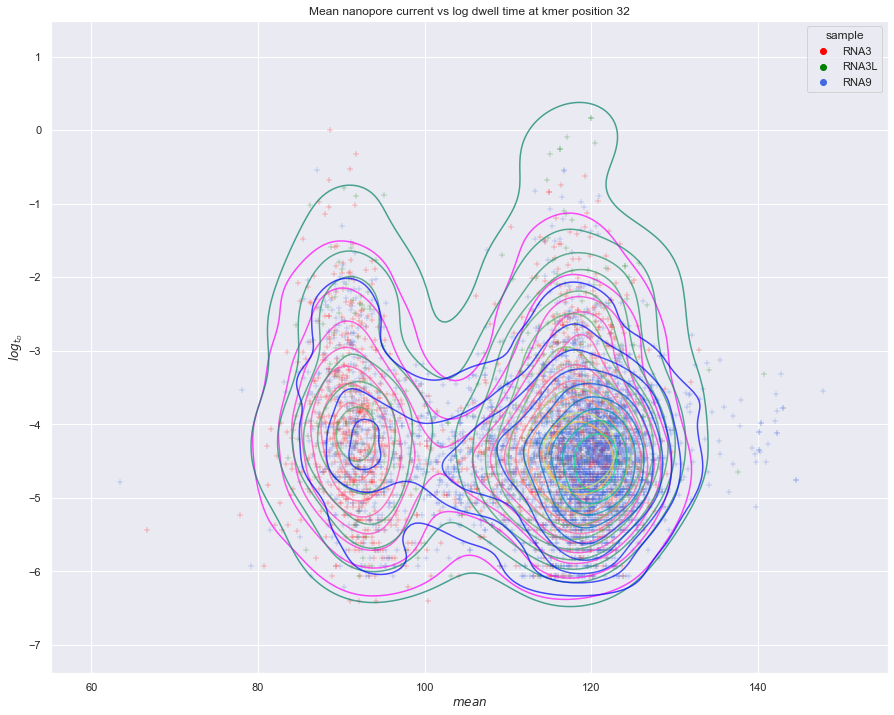

In [18]:
df = df3.append(df3l)
df = df.append(df9)

# plot graph for a specific kmer
kmer = 32

indx = df['pos']==kmer
ax = sns.scatterplot(y='logdwell', x='mean', hue='sample', marker="+", alpha=0.5, data=df[indx], palette=['red', 'green', 'royalblue'])

# find all the indices that corrspond to this kmer (now it's randomly mixed in 'pos' column)
indx = df3['pos']==kmer
data=df3[indx]
ax = sns.kdeplot(data=data, x='mean', y='logdwell',
                 cmap="spring", n_levels=10, alpha=0.7)

# same for the ligand-RNA3 dataframe
indx = df3l['pos']==kmer
data=df3l[indx]
ax = sns.kdeplot(data=data, x='mean', y='logdwell',
                 cmap="summer", n_levels=10, alpha=0.7)

# same for RNA9
indx = df9['pos']==kmer
data=df9[indx]
ax = sns.kdeplot(data=data, x='mean', y='logdwell',
                 cmap="winter", n_levels=10, alpha=0.7)

ax.set_xlabel("$mean$")
ax.set_ylabel("$log_{t_D}$")
ax.set_title("Mean nanopore current vs log dwell time at kmer position " + str(kmer))
plt.savefig('RNA3ph9_mean_dwell_kmer{}.png'.format(kmer), dpi=300)

In [17]:
data.head()

sample  pos  logdwell        mean      median
67    RNA3   32 -4.346659  121.293442  123.592003
176   RNA3   32 -4.751353  103.288689  107.798851
444   RNA3   32 -4.752511  117.701126  117.499496
518   RNA3   32 -3.628349  123.036537  123.873001
595   RNA3   32 -4.226049  128.485489  128.989990

# RNA3 + RNA9, batch plot (in one graph)

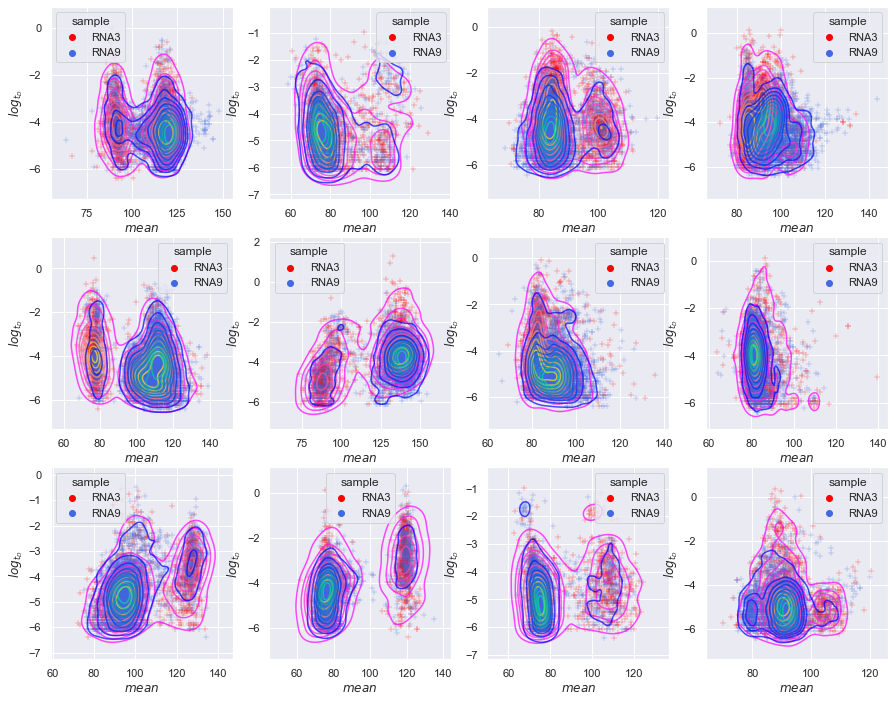

In [19]:
# specify the range of positions (bases) here
kmer = np.arange(32, 44)
df = df3.append(df9)

for k in range(len(kmer)):
    plt.subplot(3,4,k+1)
    indx = df['pos']==kmer[k]
    ax = sns.scatterplot(y='logdwell', x='mean', hue='sample', marker="+", alpha=0.5, data=df[indx], palette=['red', 'royalblue'])
    
    indx = df3['pos']==kmer[k]
    data=df3[indx]
    ax = sns.kdeplot(data=data, x='mean', y='logdwell',
                 cmap="spring", n_levels=10, alpha=0.7)


    indx = df9['pos']==kmer[k]
    data=df9[indx]
    ax = sns.kdeplot(data=data, x='mean', y='logdwell',
                 cmap="winter", n_levels=10, alpha=0.7)

    ax.set_xlabel("$mean$")
    ax.set_ylabel("$log_{t_D}$")
    plt.savefig('RNA39_mean_dwell_kmers{}_{}'.format(kmer[0], kmer[-1]), dpi=300)

# Distribution difference (naïve delta) plot

In [20]:
from scipy.stats import norm
from sklearn.neighbors import KernelDensity

# find the kernel density function for two 1d distributions and calc the difference
def calc_delta_kde(dfg, dfm, column, kmer):
    N = 1000 # kde sampling number
    
    indxg = dfg['pos']==kmer
    datag = dfg[indxg]
    xg = datag[column]

    indxm = dfm['pos']==kmer
    datam = dfm[indxm]
    xm = datam[column]
    
    # if the number of data points for this kmer is > 10 (otherwise it's difficult to have a distribution)
    if len(datag)>10 and len(datam)>10:

        x_min, x_max = min(min(xg), min(xm)), max(max(xg), max(xm))
        x_range = np.linspace(x_min, x_max, N)

        kdexg = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(np.array(xg).reshape(-1, 1))
        xg_kde = np.exp(kdexg.score_samples(x_range.reshape(-1, 1)))

        kdexm = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(np.array(xm).reshape(-1, 1))
        xm_kde = np.exp(kdexm.score_samples(x_range.reshape(-1, 1)))

        delta = np.sum(np.abs(xg_kde - xm_kde))

        #ax = plt.plot(x_range, xm_kde, x_range, xg_kde)
        #plt.legend(title='naïve $\Delta_{KDE}$ median = ' + str(round(delta, 3)), title_fontsize='x-large', loc='upper right', frameon=False)

    else:
        return 0
    
    return delta


In [13]:
def make_df_delta(dfg, dfm, pos):
    
    pos = np.array(pos.flatten())
    delta_median = []
    for kmer in pos:
        delta_median.append(calc_delta_kde(dfg, dfm, 'median', int(kmer)))
        
    delta_dwell = []
    for kmer in pos:
        delta_dwell.append(calc_delta_kde(dfg, dfm, 'logdwell', int(kmer)))
        
    delta_median = np.array(delta_median)
    delta_dwell = np.array(delta_dwell)

    data = np.vstack((pos, delta_median))
    data = np.vstack((data, delta_dwell))

    return data.T

delta = make_df_delta(df3, df9, data3[:,0])


# Plot the delta graph (1D) with Bokeh

In [14]:
output_file('out_bokeh_delta.html')

def view_aln_delta(seqs, ids, delta, fontsize="9pt", plot_width=800):
    """Bokeh sequence alignment view"""

    #make sequence and id lists from the aln object  
    text = [i for s in list(seqs) for i in s]
    colors = get_colors(seqs)    
    N = len(seqs[0])
    S = len(seqs)    
    width = .4

    x = np.arange(1,N+1)
    # OFFSET FOR THE SEQ SO IT STARTS EXACTLY AT 0
    x = x - 0.5
    y = np.arange(0,S,1)
    #creates a 2D grid of coords from the 1D arrays
    xx, yy = np.meshgrid(x, y)
    #flattens the arrays
    gx = xx.ravel()
    gy = yy.flatten()
    #use recty for rect coords with an offset
    recty = gy+.5
    h= 1/S
    #now we can create the ColumnDataSource with all the arrays
    source = ColumnDataSource(dict(x=gx, y=gy, recty=recty, text=text, colors=colors))
    plot_height = len(seqs)*15+50
    x_range = Range1d(0, N+1, bounds='auto')
    if N>150:
        viewlen=150
    else:
        viewlen=N
    #view_range is for the close up view
    view_range = (0, viewlen)
    tools="xpan, xwheel_zoom, reset, save"

    #plot of the values of interest
    p = figure(title=None, plot_width= plot_width, plot_height=400,
               x_range=view_range, background_fill_color='#f8f8f8',
               tools=tools, toolbar_location='below')
    # OFFSET BY 0.5 so points correspond precisely to bases
    #p.scatter(x=delta[:,0]+0.5, y=delta[:,1], marker="circle_x", line_color="#6666ee", 
    #          fill_color="#ee6666", fill_alpha=0.5, size=8,
    #          legend_label='naïve Delta_KDE median')
    #p.line(x=delta[:,0]+0.5, y=delta[:,1], line_width=2, alpha=0.7, color="#cf3c4d")
    p.scatter(x=delta[:,0]+0.5, y=delta[:,2], marker="circle_x", line_color="#6666ee", 
              fill_color='#00a5a9', fill_alpha=0.5, size=8,
              legend_label='naïve Delta_KDE logdwell') 
    p.line(x=delta[:,0]+0.5, y=delta[:,2], line_width=2, alpha=0.7, color="#cf3c4d")
    
    low_box = BoxAnnotation(left=12, fill_alpha=0.0, fill_color='green')
    mid_box = BoxAnnotation(left=12, right=27, fill_alpha=0.1, fill_color='orange')
    high_box = BoxAnnotation(right=27, fill_alpha=0.0, fill_color='green')
    p.add_layout(low_box)
    p.add_layout(mid_box)
    p.add_layout(high_box)
    #band3 = Band(base=data3[:,1], lower=data3[:,1]-data3[:,3], upper=data3[:,1]+data3[:,3], level='underlay',
    #        fill_alpha=0.3, line_width=0, line_color='black', source=source)
    #band9 = Band(base=data9[:,1], lower=data9[:,1]-data9[:,3], upper=data9[:,1]+data9[:,3], level='underlay',
    #        fill_alpha=0.3, line_width=0, line_color='black', source=source)
    #p.add_layout(band3)
    #p.add_layout(band3)
    
    p.xgrid.ticker = SingleIntervalTicker(interval=1)
    p.yaxis.visible = True
    p.xaxis.visible = False
    p.grid.visible = True  

    #sequence text view with ability to scroll along x axis
    p1 = figure(title=None, plot_width=plot_width, plot_height=plot_height,
                x_range=view_range, y_range=ids, tools="xpan,reset",
                min_border=0, toolbar_location='below')#, lod_factor=1)          
    glyph = Text(x="x", y="y", text="text", text_align='center',text_color="black",
                text_font="monospace",text_font_size=fontsize)
    rects = Rect(x="x", y="recty",  width=1, height=1, fill_color="colors",
                line_color=None, fill_alpha=0.4)
    p1.add_glyph(source, glyph)
    p1.add_glyph(source, rects)

    p1.grid.visible = False
    p1.xaxis.major_label_text_font_style = "bold"
    p1.yaxis.minor_tick_line_width = 0
    p1.yaxis.major_tick_line_width = 0

    p = gridplot([[p],[p1]], toolbar_location='below')
    return p


p = view_aln_delta([RNA3_seq, RNA3_seq], ['RNA3', 'RNA3L'], delta, plot_width=1200)
#bokeh_pane = pn.pane.Bokeh(height=100,margin=10)
#pn.pane.Bokeh(p)

show(p)

# Plot batch (2D+marginal) into separate files with the delta info

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


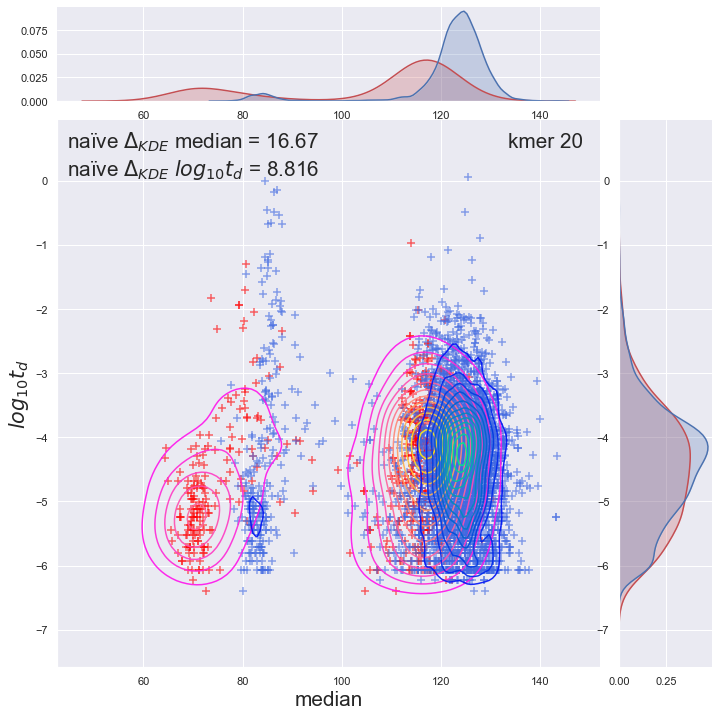

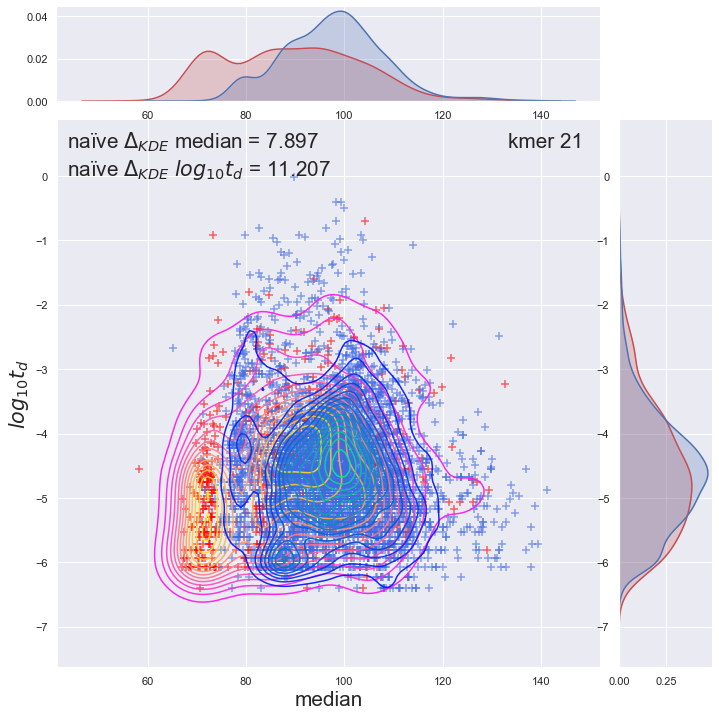

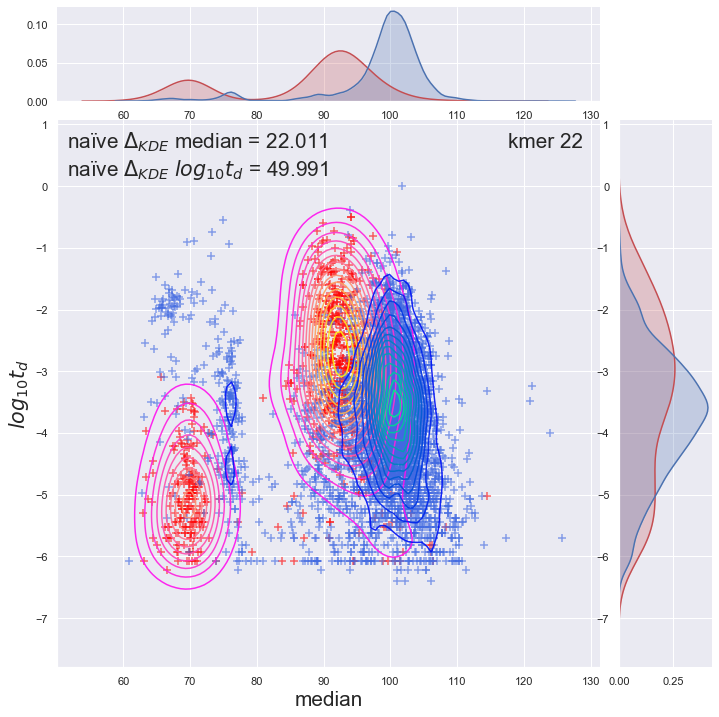

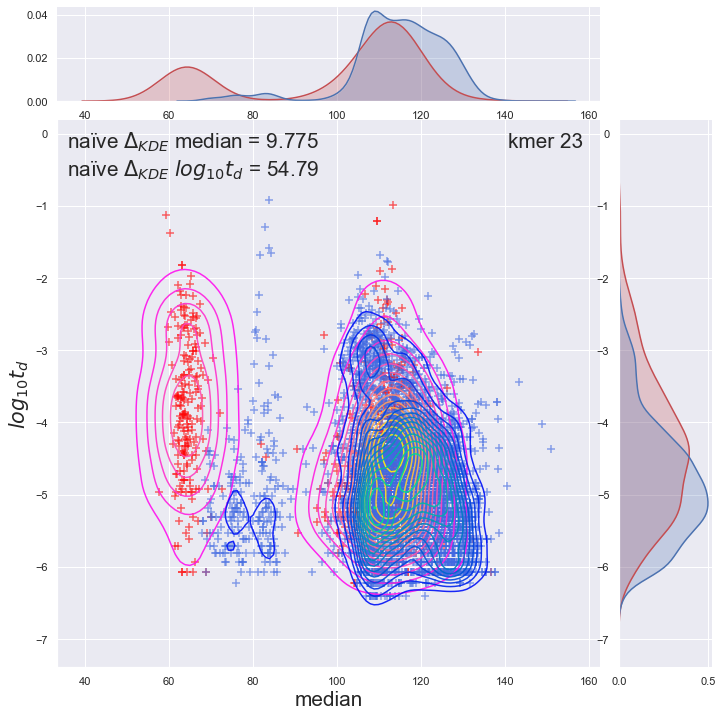

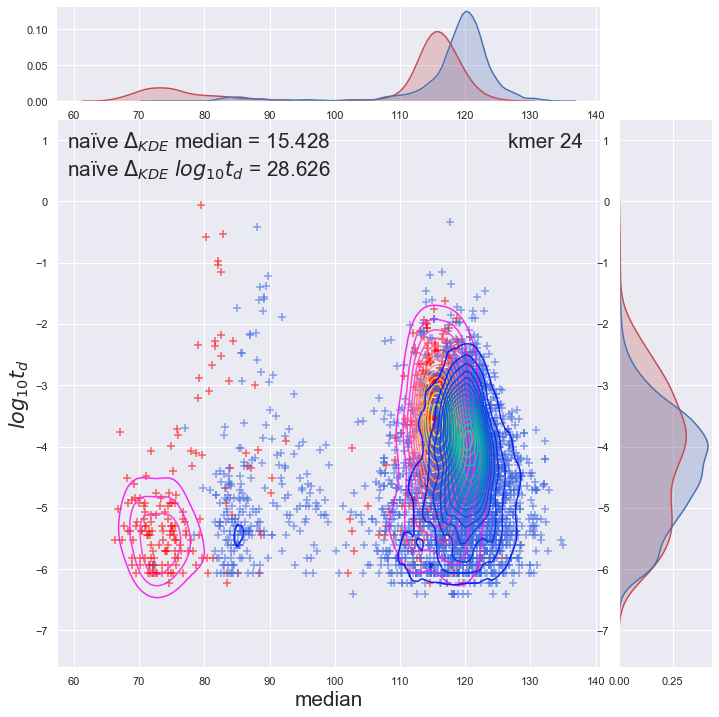

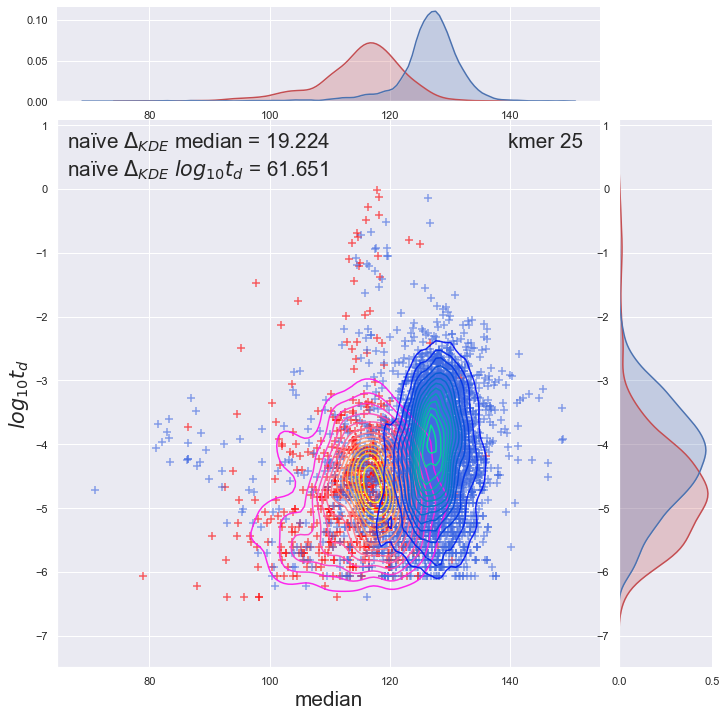

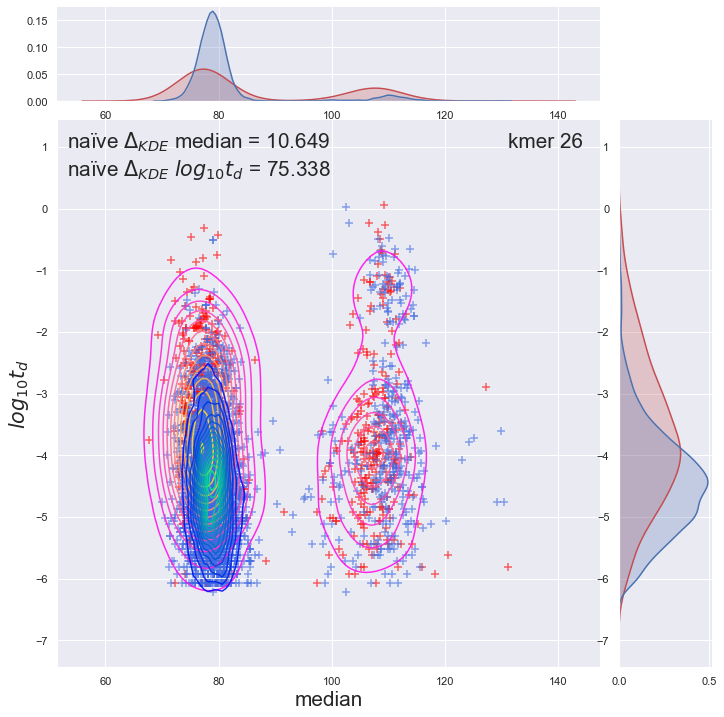

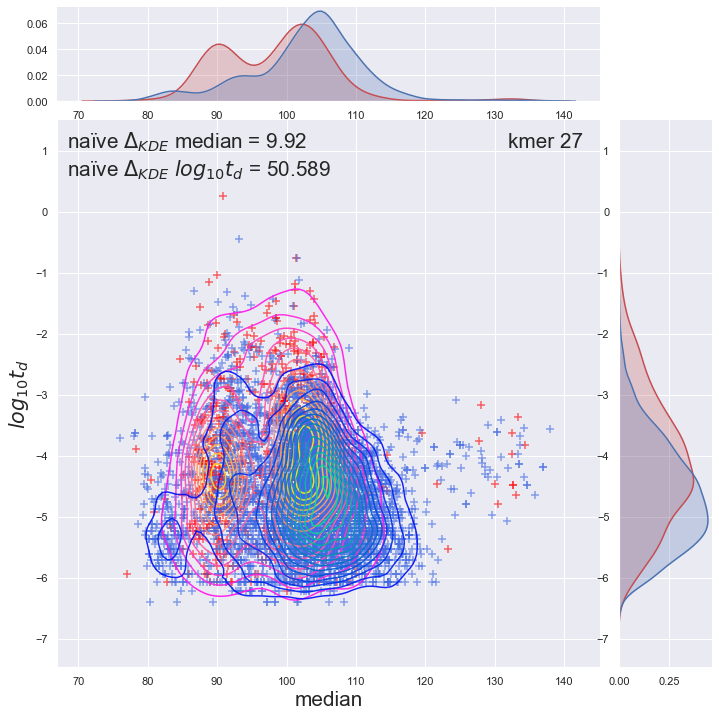

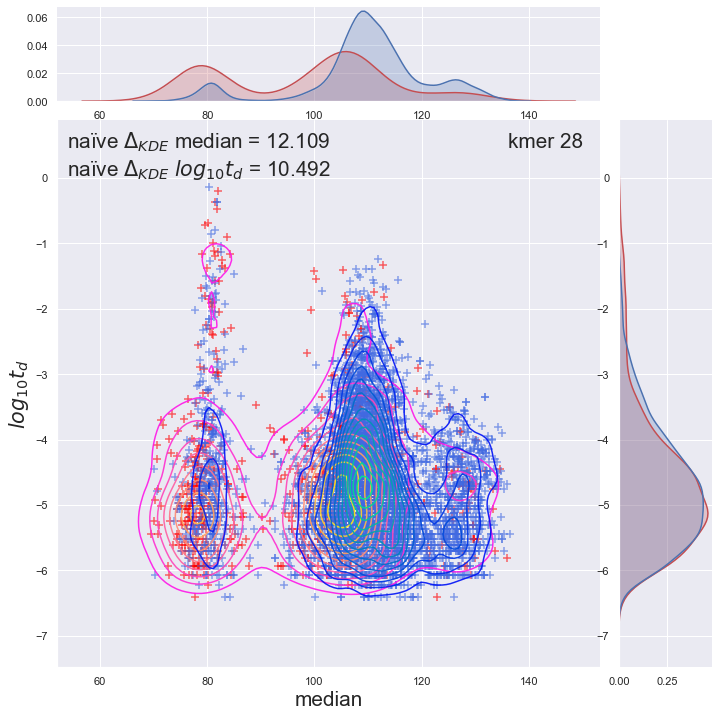

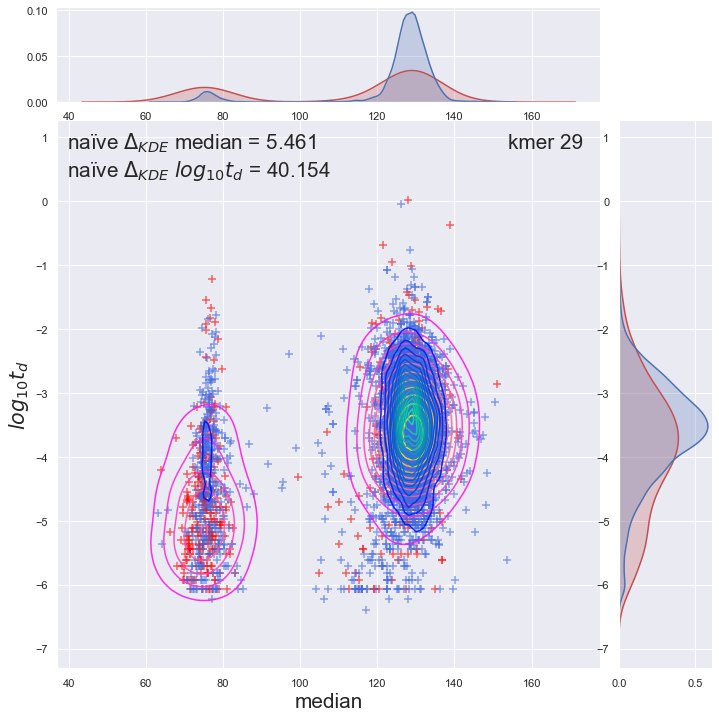

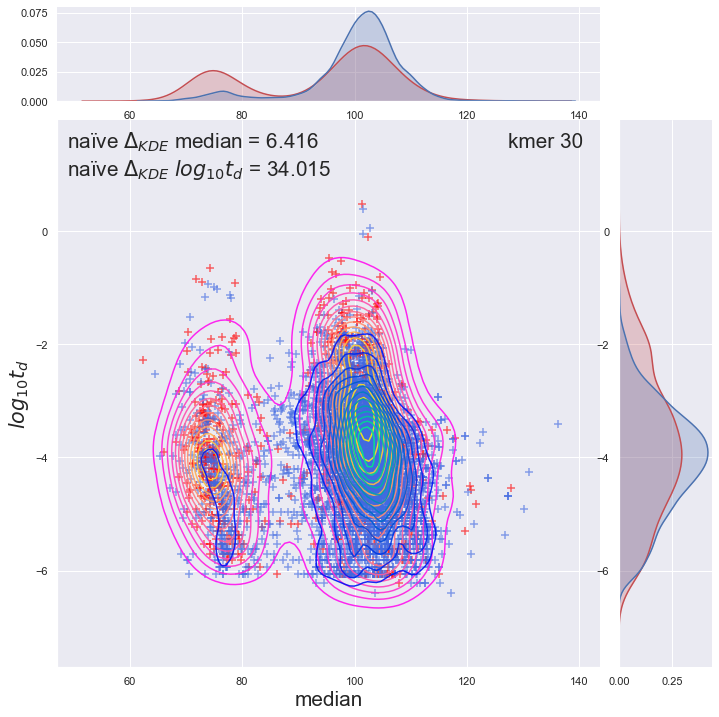

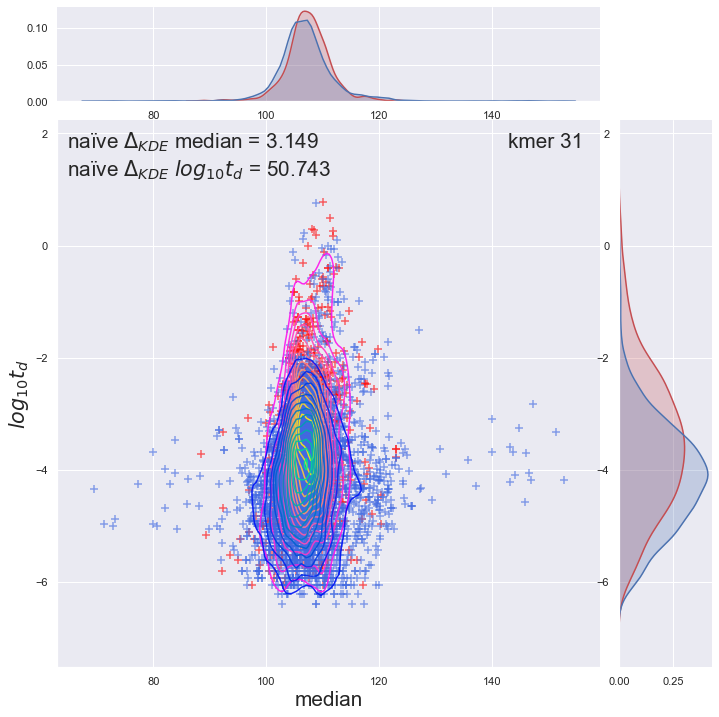

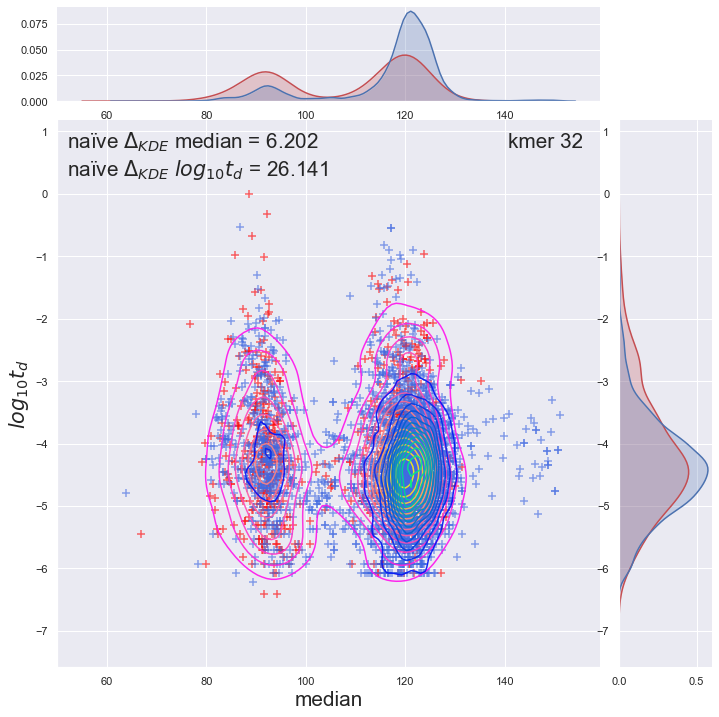

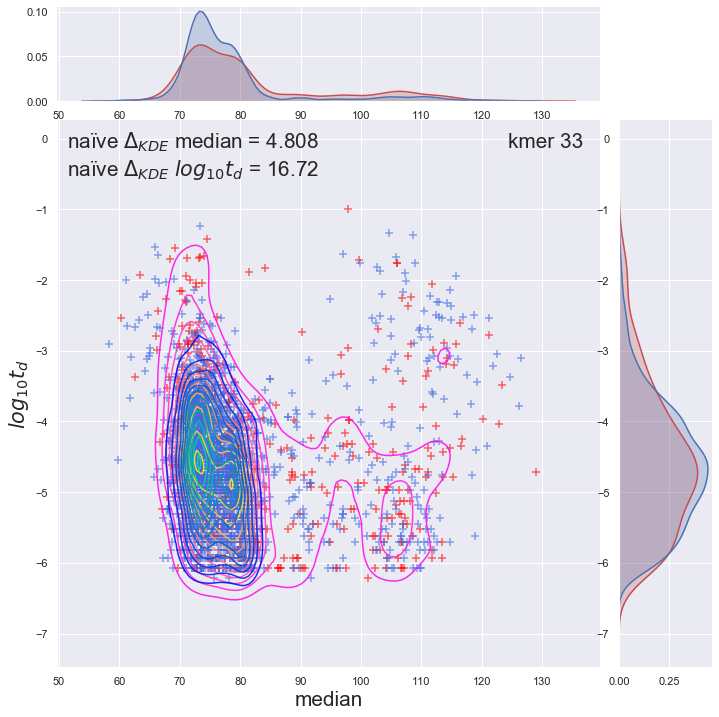

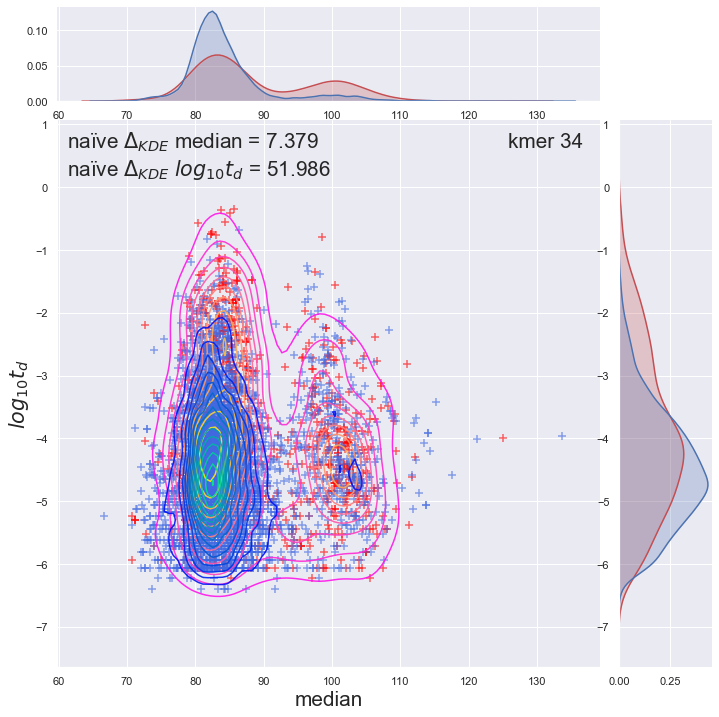

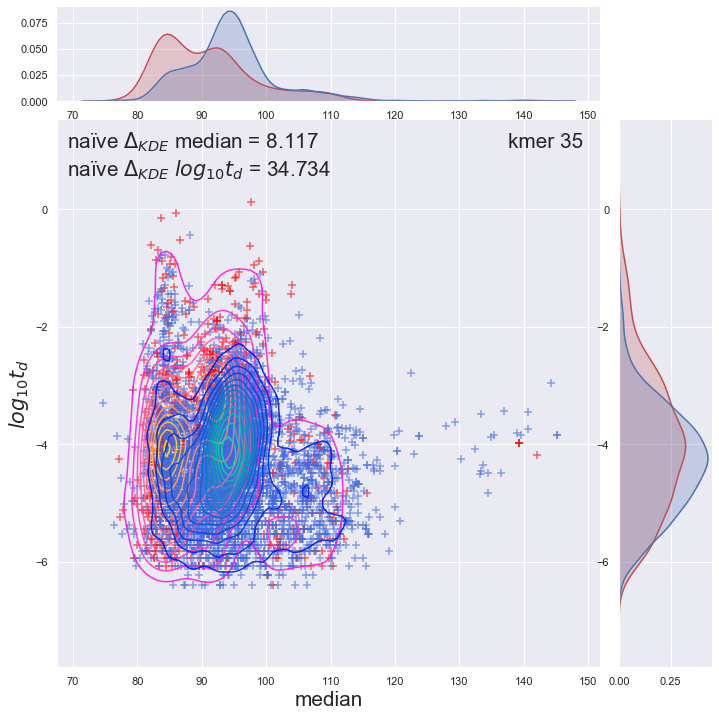

In [15]:
from IPython.display import clear_output

def jointplot_batch(dfg, dfm, path='./RNA3/', kmer=32):
    
    # PLOT PARAMETERS
    xaxis = 'median'
    alpha_scatter = 0.6
    alpha_kde = 0.9
    n_levels = 15
    colormaps = ['spring', 'winter']
    shade = False
    marker_size = 50
    marker_type = '+'
    fontsize='xx-large'
    # %%%%%%%%%%%%%%%%

    indx = dfg['pos']==kmer
    data = dfg[indx]

    axs = sns.jointplot(x=xaxis, y='logdwell', data=data, kind="scatter", color='red', 
                        marker=marker_type, height=10, alpha=alpha_scatter, s=marker_size)

    axs.plot_joint(sns.kdeplot, zorder=2, n_levels=n_levels, cmap=colormaps[0], 
                   alpha=alpha_kde, shade=shade)

    # draw a KDE instead of hist
    axs.ax_marg_x.cla()
    axs.ax_marg_y.cla()
    sns.distplot(data[xaxis], ax=axs.ax_marg_x, hist=False, color='r', kde_kws={"shade": True})
    sns.distplot(data['logdwell'], ax=axs.ax_marg_y, vertical=True, hist=False, color='r', kde_kws={"shade": True})

    # calculate the KDE differences!
    delta_m = calc_delta_kde(dfg, dfm, 'median', kmer)
    delta_t = calc_delta_kde(dfg, dfm, 'logdwell', kmer)
    
    legend_text = 'naïve $\Delta_{KDE}$ median = '+str(round(delta_m, 3))+\
            '\n'+'naïve $\Delta_{KDE}$ $log_{10}t_d$ = '+str(round(delta_t, 3))
            #'\n'+'kmer {}'.format(kmer)
    axs.ax_joint.legend(title=legend_text, title_fontsize=fontsize, loc='upper left', frameon=False)
    #axs.ax_joint.text(124, 1.05, 'kmer {}'.format(kmer), fontsize=fontsize)
    axs.ax_joint.text(0.9, 0.96, 'kmer {}'.format(kmer), fontsize=fontsize,
                     horizontalalignment='center',
                     verticalalignment='center',
                     transform = axs.ax_joint.transAxes)

    indx = dfm['pos']==kmer
    data = dfm[indx]

    axs.x = data[xaxis]
    axs.y = data['logdwell']

    axs.ax_joint.scatter(xaxis, 'logdwell', data=data, color='royalblue', marker=marker_type, 
                         alpha=alpha_scatter, s=marker_size)
    axs.plot_joint(sns.kdeplot, zorder=3, n_levels=n_levels, cmap=colormaps[1], 
                   alpha=alpha_kde, shade=shade)

    #from matplotlib.legend import Legend
    #leg = Legend(axs.ax_joint, loc='lower right', frameon=False)
    #axs.ax_joint.add_artist(leg)

    sns.distplot(data[xaxis], ax=axs.ax_marg_x, hist=False, color='b', kde_kws={"shade": True})
    sns.distplot(data['logdwell'], ax=axs.ax_marg_y, vertical=True, hist=False, color='b', kde_kws={"shade": True})

    axs.set_axis_labels(xaxis, "$log_{10} t_d$", fontsize=fontsize)
    axs.ax_marg_x.set_xlabel("")
    axs.ax_marg_y.set_ylabel("")

    axs.savefig(path + xaxis + '_dwell_kmer_{}.png'.format(kmer), dpi=200)
    return
    

# define the kmer range here
# and path to save figures
kmers = range(20,36)
for k in kmers:
    jointplot_batch(df3, df9, path='./RNA3/', kmer=k)